Using device: cpu
🔧 Initializing AI Trading Analyzer...
🚀 LAUNCHING AI-POWERED TRADING ANALYSIS FOR AAPL 🚀

📈 Processing 15min Interval...
⬇️ Fetching data for AAPL (15min)...
🤖 Training autoencoder...
Epoch [10/50], Loss: 0.001798
Epoch [20/50], Loss: 0.001744
Epoch [30/50], Loss: 0.000929
Epoch [40/50], Loss: 0.000484
Epoch [50/50], Loss: 0.000244
✅ Autoencoder training complete!
🔎 Anomaly detection complete. Threshold: 0.1014
📊 Found 68 anomalies out of 1389 data points


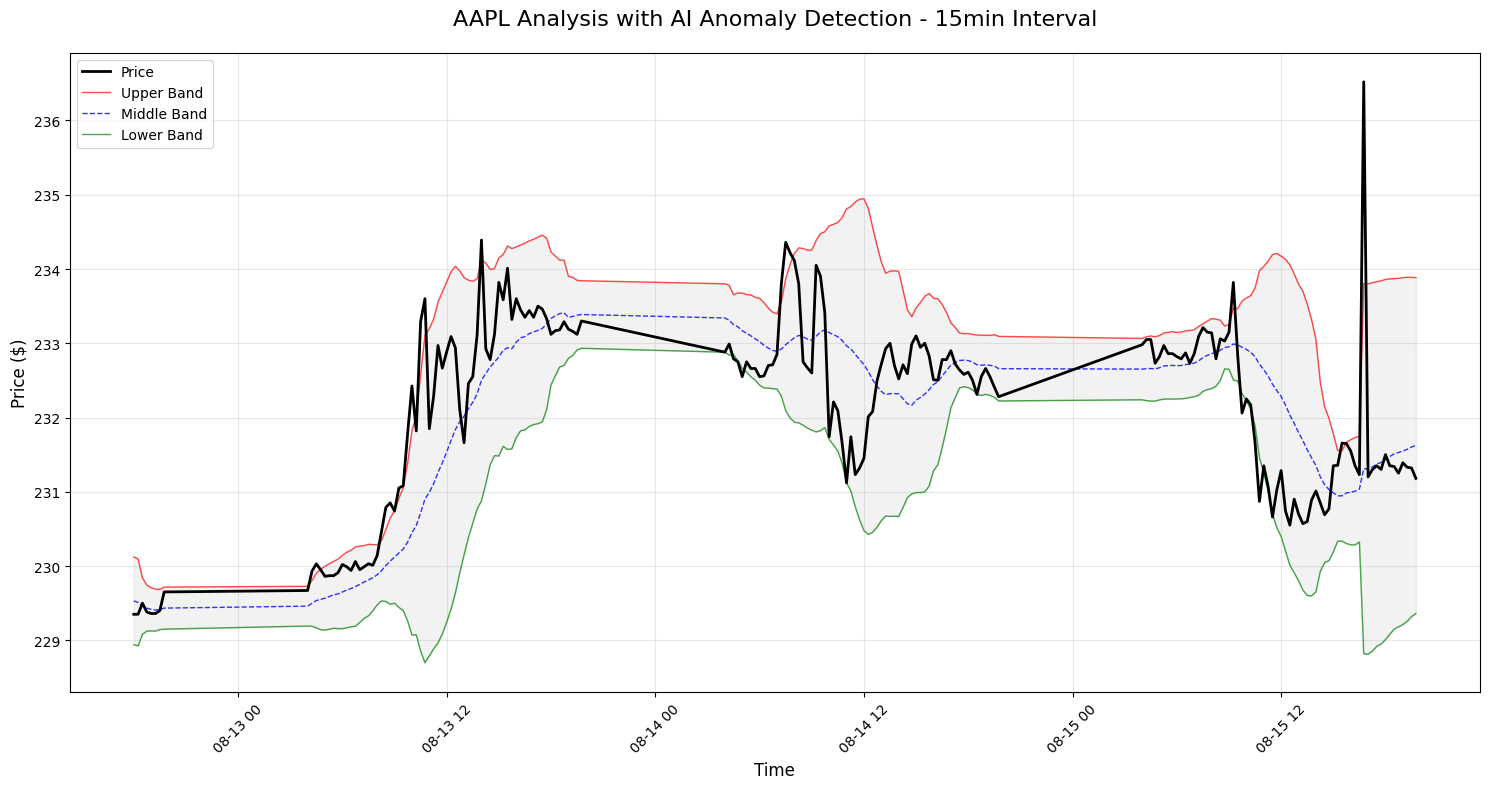

🔮 INSIGHT (15min Interval): No significant anomalies detected in recent periods.
   Market appears to be following normal Bollinger Band patterns.
📊 STATISTICS (15min Interval): 68 anomalies detected (4.9% of data)

📈 Processing 60min Interval...
⬇️ Fetching data for AAPL (60min)...
🤖 Training autoencoder...
Epoch [10/50], Loss: 0.000852
Epoch [20/50], Loss: 0.000770
Epoch [30/50], Loss: 0.000692
Epoch [40/50], Loss: 0.000601
Epoch [50/50], Loss: 0.000557
✅ Autoencoder training complete!
🔎 Anomaly detection complete. Threshold: 0.1838
📊 Found 16 anomalies out of 333 data points


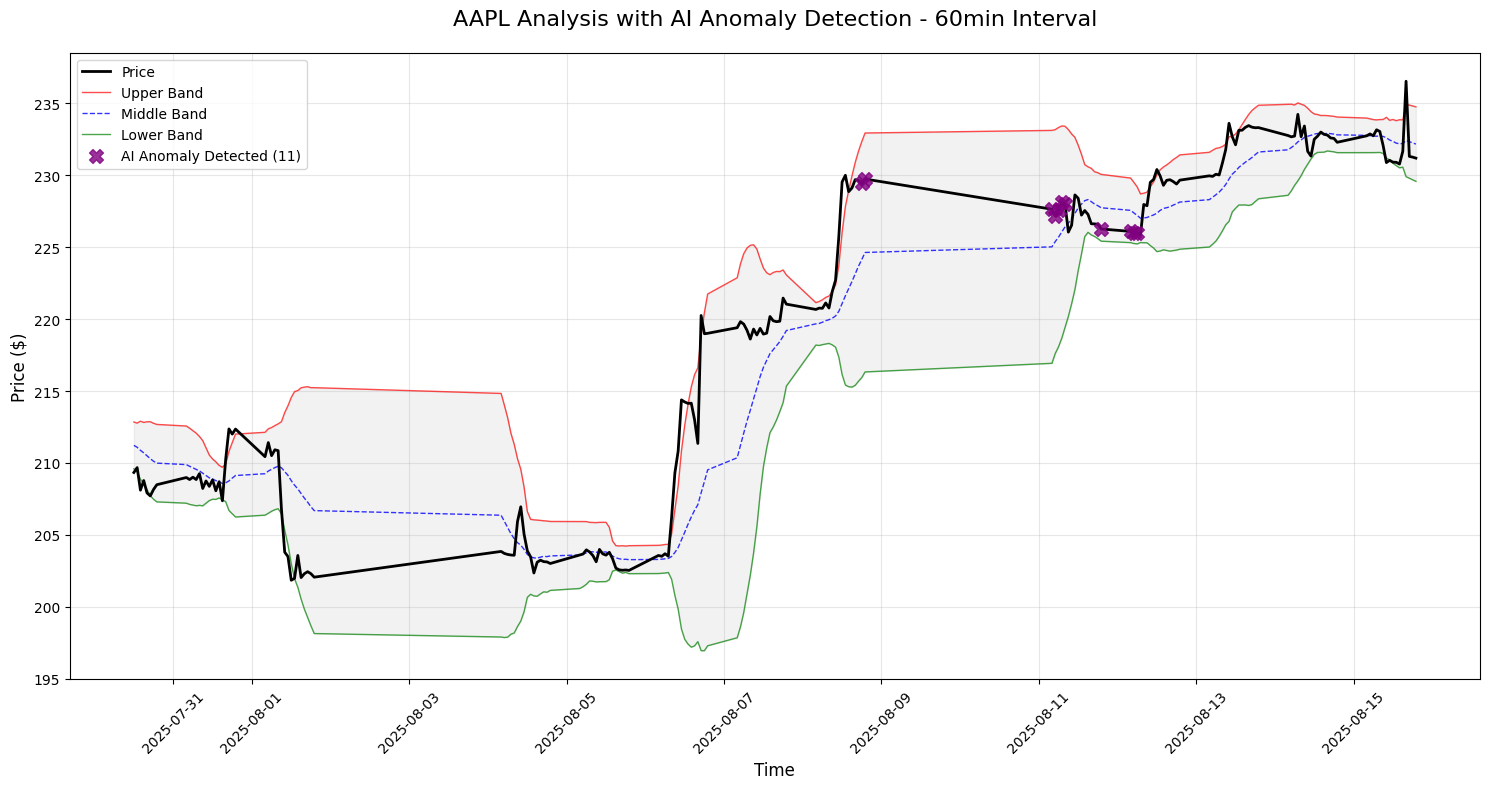

🔮 INSIGHT (60min Interval): No significant anomalies detected in recent periods.
   Market appears to be following normal Bollinger Band patterns.
📊 STATISTICS (60min Interval): 16 anomalies detected (4.8% of data)

✅ ANALYSIS COMPLETE
💡 TIP: Anomalies indicate unusual market behavior that may precede significant price movements.


In [1]:
#1 data creating code
# Cell 2: Imports and Setup
import requests
import json
from dotenv import load_dotenv
import os
import pandas as pd
from datetime import date, datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')

# Load environment variables and setup
load_dotenv()
ALPHA_VANTAGE_API_KEY = os.getenv('ALPHA_VANTAGE_API_KEY')  # Use 'demo' as fallback
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# Configuration constants
SYMBOL = "AAPL"
SEQUENCE_LENGTH = 30
LEARNING_RATE = 0.001
EPOCHS = 50
BATCH_SIZE = 32

# Cell 2a: Autoencoder Model Definition
class BollingerAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, latent_dim=16):
        super(BollingerAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, latent_dim)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

def create_sequences(data, seq_length):
    """Create sequences for autoencoder training."""
    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequences.append(data[i:i + seq_length].flatten())
    return np.array(sequences)

def train_autoencoder(model, data, epochs=EPOCHS, batch_size=BATCH_SIZE):
    """Train the autoencoder model."""
    if len(data) < SEQUENCE_LENGTH + 10:
        print("❌ Insufficient data for training autoencoder.")
        return None, None
    
    print("🤖 Training autoencoder...")
    
    # Prepare data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    sequences = create_sequences(scaled_data, SEQUENCE_LENGTH)
    
    if len(sequences) < 10:
        print("❌ Not enough sequences for training.")
        return None, None
    
    # Convert to tensors
    tensor_data = torch.FloatTensor(sequences).to(DEVICE)
    dataset = TensorDataset(tensor_data, tensor_data)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Training setup
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.MSELoss()
    
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_data, _ in dataloader:
            optimizer.zero_grad()
            reconstructed = model(batch_data)
            loss = criterion(reconstructed, batch_data)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader):.6f}")
    
    print("✅ Autoencoder training complete!")
    return model, scaler

# Cell 2b: Integrated TradingAnalyzer Class and Execution
class TradingAnalyzer:
    def __init__(self, api_key):
        self.api_key = api_key
        self.model = BollingerAutoencoder(input_dim=SEQUENCE_LENGTH * 3).to(DEVICE)

    def fetch_bollinger_bands(self, symbol, interval):
        """Fetch Bollinger Bands data with a timeout."""
        print(f"⬇️ Fetching data for {symbol} ({interval})...")
        try:
            # --- MODIFICATION 1: Added timeout to the API request ---
            bbands_params = {
                "function": "BBANDS",
                "symbol": symbol,
                "interval": interval,
                "time_period": 20,
                "series_type": "close",
                "apikey": self.api_key
            }
            response = requests.get("https://www.alphavantage.co/query", params=bbands_params, timeout=20)
            data = response.json()

            if 'Technical Analysis: BBANDS' not in data:
                print(f"❌ API Error: {data.get('Note', 'No BBANDS data found.')}")
                return None

            df = pd.DataFrame.from_dict(data['Technical Analysis: BBANDS'], orient='index')
            df.columns = ['upper', 'middle', 'lower']
            df = df.apply(pd.to_numeric, errors='coerce')
            df.index = pd.to_datetime(df.index)

            # --- MODIFICATION 2: Added timeout to the second API request ---
            price_params = {
                "function": "TIME_SERIES_INTRADAY",
                "symbol": symbol,
                "interval": interval,
                "apikey": self.api_key,
                "outputsize": "full"
            }
            price_response = requests.get("https://www.alphavantage.co/query", params=price_params, timeout=20)
            price_response_data = price_response.json()
            
            # Check if price data is available
            time_series_key = f'Time Series ({interval})'
            if time_series_key not in price_response_data:
                print(f"❌ Price data not available: {price_response_data.get('Note', 'Unknown error')}")
                return None
                
            price_data = price_response_data[time_series_key]
            price_df = pd.DataFrame.from_dict(price_data, orient='index')['4. close']
            price_df.index = pd.to_datetime(price_df.index)
            price_df = price_df.astype(float)
            price_df.name = 'close'  # Ensure the column is named 'close'
            
            df = df.join(price_df).dropna()
            return df.sort_index()
            
        # --- MODIFICATION 3: Added exception handling for timeouts and other request errors ---
        except requests.exceptions.Timeout:
            print("❌ API request timed out. The server is not responding.")
            return None
        except Exception as e:
            print(f"❌ An error occurred during data fetching: {e}")
            return None

    def generate_mock_data(self, days=90):
        """Generate realistic mock data if API fails."""
        print("🎭 Generating mock data...")
        dates = pd.date_range(end=datetime.now(), periods=days*24, freq='H')
        
        # Generate more realistic price movement
        np.random.seed(42)  # For reproducible results
        base_price = 150
        returns = np.random.normal(0, 0.02, len(dates))  # 2% daily volatility
        price = base_price * np.exp(np.cumsum(returns))
        
        df = pd.DataFrame(index=dates, data={'close': price})
        df['middle'] = df['close'].rolling(20).mean()
        df['std'] = df['close'].rolling(20).std()
        df['upper'] = df['middle'] + (2 * df['std'])
        df['lower'] = df['middle'] - (2 * df['std'])
        
        return df[['upper', 'middle', 'lower', 'close']].dropna()

    def detect_anomalies_with_autoencoder(self, df):
        """Detect anomalies using the trained autoencoder."""
        # Ensure we have all required columns
        required_cols = ['upper', 'middle', 'lower', 'close']
        missing_cols = [col for col in required_cols if col not in df.columns]
        if missing_cols:
            print(f"❌ Missing required columns: {missing_cols}")
            print(f"Available columns: {list(df.columns)}")
            df['anomaly'] = False
            df['anomaly_score'] = 0.0
            return df
            
        bbands_df = df[['upper', 'middle', 'lower']].copy()
        
        trained_model, scaler = train_autoencoder(self.model, bbands_df)
        
        if trained_model is None:
            df['anomaly'] = False
            df['anomaly_score'] = 0.0
            return df

        scaled_data = scaler.transform(bbands_df)
        sequences = create_sequences(scaled_data, SEQUENCE_LENGTH)
        
        if len(sequences) == 0:
            print("❌ Not enough data to create sequences for anomaly detection.")
            df['anomaly'] = False
            df['anomaly_score'] = 0.0
            return df
            
        trained_model.eval()
        with torch.no_grad():
            sequences_tensor = torch.FloatTensor(sequences).to(DEVICE)
            reconstructions = trained_model(sequences_tensor)
            loss = torch.sum((reconstructions - sequences_tensor)**2, axis=1).cpu().numpy()
        
        anomaly_scores = np.full(len(df), np.nan)
        anomaly_scores[SEQUENCE_LENGTH-1:SEQUENCE_LENGTH-1+len(loss)] = loss
        
        threshold = np.nanquantile(anomaly_scores, 0.95)
        df['anomaly_score'] = anomaly_scores
        df['anomaly'] = df['anomaly_score'] > threshold
        
        print(f"🔎 Anomaly detection complete. Threshold: {threshold:.4f}")
        print(f"📊 Found {df['anomaly'].sum()} anomalies out of {len(df)} data points")
        return df

    def visualize_data(self, df, interval_name):
        """Create visualization of data and detected anomalies."""
        # Check if required columns exist
        required_cols = ['upper', 'middle', 'lower', 'close', 'anomaly']
        missing_cols = [col for col in required_cols if col not in df.columns]
        if missing_cols:
            print(f"❌ Cannot visualize: Missing columns {missing_cols}")
            print(f"Available columns: {list(df.columns)}")
            return
            
        plt.figure(figsize=(15, 8))
        plot_df = df.tail(200).copy()
        
        # Main price and bands
        plt.plot(plot_df.index, plot_df['close'], 'black', linewidth=2, label='Price', zorder=3)
        plt.plot(plot_df.index, plot_df['upper'], 'r-', alpha=0.7, linewidth=1, label='Upper Band')
        plt.plot(plot_df.index, plot_df['middle'], 'b--', alpha=0.8, linewidth=1, label='Middle Band')
        plt.plot(plot_df.index, plot_df['lower'], 'g-', alpha=0.7, linewidth=1, label='Lower Band')
        
        # Fill between bands
        plt.fill_between(plot_df.index, plot_df['upper'], plot_df['lower'], alpha=0.1, color='gray')
        
        # Anomalies
        anomalies = plot_df[plot_df['anomaly'] == True]
        if not anomalies.empty:
            plt.scatter(anomalies.index, anomalies['close'], color='purple', s=100,
                        marker='X', label=f'AI Anomaly Detected ({len(anomalies)})', zorder=5, alpha=0.8)
            
        plt.title(f'{SYMBOL} Analysis with AI Anomaly Detection - {interval_name}', fontsize=16, pad=20)
        plt.xlabel('Time', fontsize=12)
        plt.ylabel('Price ($)', fontsize=12)
        plt.legend(loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def run_complete_analysis(self, symbol="AAPL"):
        """Run the end-to-end integrated analysis."""
        print(f"🚀 LAUNCHING AI-POWERED TRADING ANALYSIS FOR {symbol} 🚀")
        print("=" * 80)
        
        global SYMBOL
        SYMBOL = symbol
        
        for interval in ["15min", "60min"]:
            interval_name = f"{interval} Interval"
            print(f"\n📈 Processing {interval_name}...")
            
            df = self.fetch_bollinger_bands(symbol, interval)
            if df is None or len(df) < (SEQUENCE_LENGTH + 10):
                print(f"⚠️ API fetch failed or insufficient data for {interval_name}. Using mock data.")
                df = self.generate_mock_data()

            df_with_anomalies = self.detect_anomalies_with_autoencoder(df)
            
            self.visualize_data(df_with_anomalies, interval_name)
            
            # Analysis insights
            recent_data = df_with_anomalies.tail(24)  # Last 24 periods
            recent_anomalies = recent_data[recent_data['anomaly'] == True]
            
            if not recent_anomalies.empty:
                last_anomaly_time = recent_anomalies.index[-1].strftime('%Y-%m-%d %H:%M')
                print(f"🔮 INSIGHT ({interval_name}): Recent AI-detected anomaly on {last_anomaly_time}.")
                print(f"   Suggests unusual market dynamics. Monitor for potential trend changes.")
            else:
                print(f"🔮 INSIGHT ({interval_name}): No significant anomalies detected in recent periods.")
                print("   Market appears to be following normal Bollinger Band patterns.")
            
            # Additional statistics
            total_anomalies = df_with_anomalies['anomaly'].sum()
            anomaly_rate = (total_anomalies / len(df_with_anomalies)) * 100
            print(f"📊 STATISTICS ({interval_name}): {total_anomalies} anomalies detected ({anomaly_rate:.1f}% of data)")
        
        print("\n" + "=" * 80)
        print("✅ ANALYSIS COMPLETE")
        print("💡 TIP: Anomalies indicate unusual market behavior that may precede significant price movements.")

# --- Main Execution Block ---
if __name__ == "__main__":
    # Initialize analyzer
    print("🔧 Initializing AI Trading Analyzer...")
    analyzer = TradingAnalyzer(ALPHA_VANTAGE_API_KEY)
    
    # Run analysis
    analyzer.run_complete_analysis(SYMBOL)

In [ ]:
#2# 9  FastAPI Trading Data Backend for Next.js Integration
# fake data tho?
from fastapi import FastAPI, HTTPException, BackgroundTasks
from fastapi.middleware.cors import CORSMiddleware
from fastapi.responses import JSONResponse
from pydantic import BaseModel
from typing import Dict, List, Optional, Any
import uvicorn
import asyncio
import nest_asyncio
import json
from datetime import datetime, timedelta
import threading
import time
import pandas as pd
import numpy as np


app = FastAPI(
    title="QUBT Trading API",
    description="Real-time technical indicators and options spread suggestions",
    version="1.0.0"
)

# Configure CORS for Next.js
app.add_middleware(
    CORSMiddleware,
    allow_origins=[
        "http://localhost:3000",  # Next.js dev server
        "http://localhost:3001",  # Alternative Next.js port
        "https://your-nextjs-app.vercel.app",  # Production domain
        "https://*.vercel.app",  # All Vercel deployments
    ],
    allow_credentials=True,
    allow_methods=["GET", "POST", "PUT", "DELETE"],
    allow_headers=["*"],
)

# Global data store (in production, use Redis or database)
trading_data_store = {
    "current_indicators": None,
    "spread_suggestions": None,
    "last_updated": None,
    "is_updating": False
}

# Pydantic models for API responses
class TechnicalIndicators(BaseModel):
    symbol: str
    timestamp: str
    current_price: Dict[str, float]
    indicators: Dict[str, float]

class SpreadSuggestion(BaseModel):
    timeframe: str
    expiration_date: str
    expected_move: float
    call_spread: Dict[str, Any]
    put_spread: Dict[str, Any]
    technical_justification: List[str]

class SpreadAnalysis(BaseModel):
    market_bias: str
    bias_strength: float
    support_levels: List[float]
    resistance_levels: List[float]
    spread_suggestions: List[SpreadSuggestion]
    overall_recommendation: str

class APIResponse(BaseModel):
    success: bool
    data: Optional[Any] = None
    message: Optional[str] = None
    timestamp: str

# Integrated trading functions
def get_current_technical_indicators(symbol: str = "QUBT"):
    """
    Simulate fetching current technical indicators
    In production, replace with actual market data API calls
    """
    # Mock data - replace with actual API calls to your data provider
    current_data = {
        "symbol": symbol,
        "timestamp": datetime.now().isoformat(),
        "current_price": {
            "price": 12.45,
            "change": 0.75,
            "change_percent": 6.4,
            "volume": 1250000,
            "avg_volume": 850000
        },
        "indicators": {
            "EMA_10": 11.85,
            "EMA_20": 11.20,
            "SMA_50": 10.90,
            "RSI": 68.2,
            "MACD": 0.0234,
            "MACD_Signal": 0.0189,
            "MACD_Histogram": 0.0045,
            "BB_Upper": 13.10,
            "BB_Middle": 11.95,
            "BB_Lower": 10.80,
            "Stoch_K": 72.5,
            "Stoch_D": 68.3,
            "Williams_R": -25.4,
            "CCI": 145.6
        }
    }
    return current_data

def suggest_vertical_spreads(current_data):
    """
    Suggest vertical spreads based on technical indicator analysis
    """
    print(f"🎯 VERTICAL SPREAD SUGGESTIONS FOR {current_data['symbol']}")
    
    # Extract key data points
    current_price = current_data.get("current_price", {}).get("price", 0)
    indicators = current_data.get("indicators", {})
    
    # Key technical levels
    ema10 = indicators.get("EMA_10", 0)
    ema20 = indicators.get("EMA_20", 0)
    sma50 = indicators.get("SMA_50", 0)
    rsi = indicators.get("RSI", 50)
    bb_upper = indicators.get("BB_Upper", 0)
    bb_lower = indicators.get("BB_Lower", 0)
    bb_middle = indicators.get("BB_Middle", 0)
    macd = indicators.get("MACD", 0)
    macd_signal = indicators.get("MACD_Signal", 0)
    
    # Determine market bias
    bullish_signals = 0
    bearish_signals = 0
    
    # EMA Analysis
    if ema10 > ema20:
        bullish_signals += 1
    else:
        bearish_signals += 1
    
    # Price vs EMAs
    if current_price > ema10:
        bullish_signals += 1
    else:
        bearish_signals += 1
    
    # RSI Analysis
    if rsi < 30:
        bullish_signals += 1  # Oversold = potential bounce
    elif rsi > 70:
        bearish_signals += 1  # Overbought = potential pullback
    
    # MACD Analysis
    if macd > macd_signal:
        bullish_signals += 1
    else:
        bearish_signals += 1
    
    # Bollinger Band Analysis
    if current_price < bb_lower:
        bullish_signals += 1  # Oversold
    elif current_price > bb_upper:
        bearish_signals += 1  # Overbought
    
    # Determine overall bias
    if bullish_signals > bearish_signals:
        market_bias = "BULLISH"
        bias_strength = bullish_signals / (bullish_signals + bearish_signals)
    else:
        market_bias = "BEARISH"
        bias_strength = bearish_signals / (bullish_signals + bearish_signals)
    
    # Calculate support and resistance levels
    support_levels = []
    resistance_levels = []
    
    # Add EMA levels
    support_levels.extend([ema10, ema20, sma50])
    resistance_levels.extend([ema10, ema20, sma50])
    
    # Add Bollinger Band levels
    support_levels.append(bb_lower)
    resistance_levels.append(bb_upper)
    
    # Filter and sort levels
    support_levels = sorted([level for level in support_levels if level > 0 and level < current_price])
    resistance_levels = sorted([level for level in resistance_levels if level > current_price])
    
    # Calculate expiration dates
    today = datetime.now()
    expirations = {
        "1 Week": today + timedelta(days=7),
        "2 Weeks": today + timedelta(days=14),
        "4 Weeks": today + timedelta(days=28),
        "6 Weeks": today + timedelta(days=42)
    }
    
    # Generate spread suggestions for each timeframe
    spread_suggestions = []
    
    for period, exp_date in expirations.items():
        # Calculate expected price range based on timeframe
        days_to_exp = (exp_date - today).days
        
        # Volatility estimate (simplified)
        if bb_upper > 0 and bb_lower > 0:
            implied_volatility = (bb_upper - bb_lower) / bb_middle
        else:
            implied_volatility = 0.20  # Default 20%
        
        # Expected move calculation
        expected_move = current_price * implied_volatility * np.sqrt(days_to_exp / 365)
        
        # CALL CREDIT SPREADS (Bearish/Neutral)
        if resistance_levels:
            short_call_strike = min(resistance_levels)
        else:
            short_call_strike = current_price + expected_move * 0.5
        
        long_call_strike = short_call_strike + (current_price * 0.05)  # 5% wide
        
        # Adjust strikes to reasonable increments
        short_call_strike = round(short_call_strike * 2) / 2  # Round to nearest $0.50
        long_call_strike = round(long_call_strike * 2) / 2
        
        # PUT CREDIT SPREADS (Bullish/Neutral)
        if support_levels:
            short_put_strike = max(support_levels)
        else:
            short_put_strike = current_price - expected_move * 0.5
        
        long_put_strike = short_put_strike - (current_price * 0.05)  # 5% wide
        
        # Adjust strikes to reasonable increments
        short_put_strike = round(short_put_strike * 2) / 2  # Round to nearest $0.50
        long_put_strike = round(long_put_strike * 2) / 2
        
        # Technical justification
        technical_justification = []
        if short_call_strike > bb_upper:
            technical_justification.append(f"Call spread above Bollinger Upper Band (${bb_upper:.2f})")
        if short_call_strike > ema10:
            technical_justification.append(f"Call spread above EMA 10 (${ema10:.2f})")
        if rsi > 60:
            technical_justification.append(f"RSI suggests potential resistance at {rsi:.1f}")
        if short_put_strike < bb_lower:
            technical_justification.append(f"Put spread below Bollinger Lower Band (${bb_lower:.2f})")
        if short_put_strike > ema20:
            technical_justification.append(f"Put spread above EMA 20 support (${ema20:.2f})")
        
        # Find next Friday for expiration
        days_until_friday = (4 - exp_date.weekday()) % 7
        if days_until_friday == 0 and exp_date.hour >= 16:
            days_until_friday = 7
        friday_date = exp_date + timedelta(days=days_until_friday)
        
        spread_suggestion = {
            "timeframe": period,
            "expiration_date": friday_date.strftime('%Y-%m-%d'),
            "expected_move": round(expected_move, 2),
            "call_spread": {
                "type": "Credit Spread",
                "short_strike": short_call_strike,
                "long_strike": long_call_strike,
                "width": round(long_call_strike - short_call_strike, 2),
                "max_profit": "Premium Collected",
                "max_loss": f"${long_call_strike - short_call_strike:.2f} - Premium",
                "breakeven": f"${short_call_strike:.2f} + Premium"
            },
            "put_spread": {
                "type": "Credit Spread",
                "short_strike": short_put_strike,
                "long_strike": long_put_strike,
                "width": round(short_put_strike - long_put_strike, 2),
                "max_profit": "Premium Collected",
                "max_loss": f"${short_put_strike - long_put_strike:.2f} - Premium",
                "breakeven": f"${short_put_strike:.2f} - Premium"
            },
            "technical_justification": technical_justification
        }
        
        spread_suggestions.append(spread_suggestion)
    
    # Overall recommendation
    if market_bias == "BULLISH":
        overall_recommendation = "Primary Focus: PUT CREDIT SPREADS - Bullish bias suggests selling puts below support"
    else:
        overall_recommendation = "Primary Focus: CALL CREDIT SPREADS - Bearish bias suggests selling calls above resistance"
    
    return {
        "market_bias": market_bias,
        "bias_strength": bias_strength,
        "support_levels": support_levels,
        "resistance_levels": resistance_levels,
        "spread_suggestions": spread_suggestions,
        "overall_recommendation": overall_recommendation,
        "expected_moves": expected_move
    }

# Background task to update data
async def update_trading_data_background(symbol: str):
    """Background task to fetch fresh trading data"""
    try:
        trading_data_store["is_updating"] = True
        
        # Get current technical indicators
        current_data = get_current_technical_indicators(symbol)
        
        # Generate spread analysis
        spread_analysis = suggest_vertical_spreads(current_data)
        
        # Store the data
        trading_data_store["current_indicators"] = current_data
        trading_data_store["spread_suggestions"] = spread_analysis
        trading_data_store["last_updated"] = datetime.now().isoformat()
        
        print(f"✅ Updated trading data for {symbol}")
        
    except Exception as e:
        print(f"❌ Error updating trading data: {e}")
    finally:
        trading_data_store["is_updating"] = False

# API Routes
@app.get("/", response_model=APIResponse)
async def root():
    """Health check endpoint"""
    return APIResponse(
        success=True,
        message="QUBT Trading API is running",
        timestamp=datetime.now().isoformat()
    )

@app.get("/api/indicators/{symbol}", response_model=APIResponse)
async def get_technical_indicators_endpoint(symbol: str, refresh: bool = False):
    """Get current technical indicators for a symbol"""
    try:
        # Force refresh if requested or data is stale
        if refresh or not trading_data_store["current_indicators"] or is_data_stale():
            await update_trading_data_background(symbol.upper())
        
        if not trading_data_store["current_indicators"]:
            raise HTTPException(status_code=404, detail="No indicator data available")
        
        return APIResponse(
            success=True,
            data=trading_data_store["current_indicators"],
            timestamp=datetime.now().isoformat()
        )
    
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))

@app.get("/api/spreads/{symbol}", response_model=APIResponse)
async def get_spread_suggestions_endpoint(symbol: str, refresh: bool = False):
    """Get vertical spread suggestions for a symbol"""
    try:
        # Force refresh if requested or data is stale
        if refresh or not trading_data_store["spread_suggestions"] or is_data_stale():
            await update_trading_data_background(symbol.upper())
        
        if not trading_data_store["spread_suggestions"]:
            raise HTTPException(status_code=404, detail="No spread data available")
        
        return APIResponse(
            success=True,
            data=trading_data_store["spread_suggestions"],
            timestamp=datetime.now().isoformat()
        )
    
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))

@app.get("/api/dashboard/{symbol}", response_model=APIResponse)
async def get_dashboard_data(symbol: str, refresh: bool = False):
    """Get complete dashboard data (indicators + spreads) for Next.js"""
    try:
        # Force refresh if requested or data is stale
        if refresh or not trading_data_store["current_indicators"] or is_data_stale():
            await update_trading_data_background(symbol.upper())
        
        dashboard_data = {
            "symbol": symbol.upper(),
            "indicators": trading_data_store["current_indicators"],
            "spreads": trading_data_store["spread_suggestions"],
            "last_updated": trading_data_store["last_updated"],
            "is_updating": trading_data_store["is_updating"]
        }
        
        return APIResponse(
            success=True,
            data=dashboard_data,
            timestamp=datetime.now().isoformat()
        )
    
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))

@app.post("/api/refresh/{symbol}")
async def refresh_data(symbol: str, background_tasks: BackgroundTasks):
    """Trigger background refresh of trading data"""
    try:
        if trading_data_store["is_updating"]:
            return APIResponse(
                success=False,
                message="Update already in progress",
                timestamp=datetime.now().isoformat()
            )
        
        background_tasks.add_task(update_trading_data_background, symbol.upper())
        
        return APIResponse(
            success=True,
            message=f"Data refresh initiated for {symbol.upper()}",
            timestamp=datetime.now().isoformat()
        )
    
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))

@app.get("/api/status")
async def get_api_status():
    """Get API status and data freshness"""
    return APIResponse(
        success=True,
        data={
            "has_indicator_data": trading_data_store["current_indicators"] is not None,
            "has_spread_data": trading_data_store["spread_suggestions"] is not None,
            "last_updated": trading_data_store["last_updated"],
            "is_updating": trading_data_store["is_updating"],
            "data_age_minutes": get_data_age_minutes()
        },
        timestamp=datetime.now().isoformat()
    )

# WebSocket endpoint for real-time updates
@app.websocket("/ws/{symbol}")
async def websocket_endpoint(websocket, symbol: str):
    """WebSocket for real-time trading data updates"""
    await websocket.accept()
    
    try:
        while True:
            # Send current data
            if trading_data_store["current_indicators"]:
                await websocket.send_json({
                    "type": "indicators",
                    "data": trading_data_store["current_indicators"],
                    "timestamp": datetime.now().isoformat()
                })
            
            if trading_data_store["spread_suggestions"]:
                await websocket.send_json({
                    "type": "spreads", 
                    "data": trading_data_store["spread_suggestions"],
                    "timestamp": datetime.now().isoformat()
                })
            
            # Wait 30 seconds before next update
            await asyncio.sleep(30)
            
    except Exception as e:
        print(f"WebSocket error: {e}")
    finally:
        await websocket.close()

# Utility functions
def is_data_stale(max_age_minutes: int = 15) -> bool:
    """Check if cached data is older than max_age_minutes"""
    if not trading_data_store["last_updated"]:
        return True
    
    last_updated = datetime.fromisoformat(trading_data_store["last_updated"])
    age = datetime.now() - last_updated
    return age.total_seconds() > (max_age_minutes * 60)

def get_data_age_minutes() -> Optional[float]:
    """Get age of cached data in minutes"""
    if not trading_data_store["last_updated"]:
        return None
    
    last_updated = datetime.fromisoformat(trading_data_store["last_updated"])
    age = datetime.now() - last_updated
    return age.total_seconds() / 60

# Startup event
@app.on_event("startup")
async def startup_event():
    """Initialize API on startup"""
    print("🚀 QUBT Trading API starting up...")
    print("📊 Ready to serve Next.js frontend")
    
    # Initialize with QUBT data
    await update_trading_data_background("QUBT")
    nest_asyncio.apply()
# Run the server
if __name__ == "__main__":
    print("🔥 Starting QUBT Trading API Server")
    print("📡 API will be available at: http://localhost:8000")
    print("QUBT data here: http://localhost:8000/api/dashboard/QUBT?refresh=true")
    print("📖 API docs available at: http://localhost:8000/docs")
    print("🔄 WebSocket endpoint: ws://localhost:8000/ws/QUBT")
    print("\n🎯 Integrated Functions:")
    print("   ✅ get_current_technical_indicators()")
    print("   ✅ suggest_vertical_spreads()")
    print("   ✅ Real-time data updates")
    print("   ✅ Background refresh tasks")

    # uvicorn.run(
    #     "main:app",  # Use app instance from current module
    #     host="0.0.0.0",
    #     port=8000,
    #     reload=True,
    #     log_level="info"
    # )



In [4]:
# 3 local generic server
import threading
import nest_asyncio
import uvicorn
import inspect
import sys
from typing import Dict, Any, Optional, List, Union
from datetime import datetime
import json

nest_asyncio.apply()

class AdaptiveServerManager:
    """
    Highly adaptive server manager that can work with any previous cell data structure
    """
    
    def __init__(self, app, default_config: Dict[str, Any] = None):
        self.app = app
        self.default_config = default_config or {
            'host': '0.0.0.0',
            'port': 8000,
            'log_level': 'info',
            'auto_docs': True
        }
        self.extracted_config = {}
        self.server_thread = None
        self.is_running = False
        
    def auto_extract_config(self, namespace: Dict[str, Any] = None) -> Dict[str, Any]:
        """
        Automatically extract configuration from the current namespace or provided data
        """
        if namespace is None:
            # Get the calling frame's globals to access previous cell variables
            frame = inspect.currentframe().f_back
            namespace = {**frame.f_globals, **frame.f_locals}
        
        config = self.default_config.copy()
        
        # Common patterns to look for
        extraction_patterns = {
            # Direct configuration variables
            'symbol': ['SYMBOL', 'symbol', 'ticker', 'TICKER', 'stock_symbol'],
            'port': ['PORT', 'port', 'server_port', 'api_port'],
            'host': ['HOST', 'host', 'server_host'],
            'log_level': ['LOG_LEVEL', 'log_level', 'logging_level'],
            
            # Analysis-specific variables
            'analysis_type': ['analysis_type', 'ANALYSIS_TYPE'],
            'model_name': ['model', 'MODEL', 'model_name'],
            'data_source': ['data_source', 'DATA_SOURCE', 'api_key'],
            'timeframe': ['interval', 'timeframe', 'INTERVAL'],
        }
        
        # Extract from direct variables
        for config_key, var_names in extraction_patterns.items():
            for var_name in var_names:
                if var_name in namespace:
                    config[config_key] = namespace[var_name]
                    break
        
        # Look for analyzer or model objects
        analyzers = self._find_objects_by_type(namespace, ['analyzer', 'model', 'trader'])
        if analyzers:
            config['analyzer'] = analyzers[0]
            # Try to extract symbol from analyzer
            if hasattr(analyzers[0], 'symbol'):
                config['symbol'] = analyzers[0].symbol
        
        # Look for DataFrames or data structures
        dataframes = self._find_dataframes(namespace)
        if dataframes:
            config['dataframes'] = dataframes
            config['data_available'] = True
        
        # Extract from configuration dictionaries
        config_dicts = self._find_config_dicts(namespace)
        for conf_dict in config_dicts:
            config.update(conf_dict)
        
        # Auto-assign port based on content
        config['port'] = self._auto_assign_port(config)
        
        self.extracted_config = config
        return config
    
    def _find_objects_by_type(self, namespace: Dict, keywords: List[str]) -> List[Any]:
        """Find objects that might be relevant (analyzers, models, etc.)"""
        objects = []
        for name, obj in namespace.items():
            if any(keyword in name.lower() for keyword in keywords):
                if not name.startswith('_') and not inspect.ismodule(obj):
                    objects.append(obj)
        return objects
    
    def _find_dataframes(self, namespace: Dict) -> List[str]:
        """Find DataFrame variables"""
        dataframes = []
        for name, obj in namespace.items():
            if hasattr(obj, 'columns') and hasattr(obj, 'index'):  # Likely a DataFrame
                dataframes.append(name)
        return dataframes
    
    def _find_config_dicts(self, namespace: Dict) -> List[Dict]:
        """Find dictionary variables that might contain configuration"""
        config_keywords = ['config', 'settings', 'params', 'options']
        configs = []
        
        for name, obj in namespace.items():
            if isinstance(obj, dict) and any(keyword in name.lower() for keyword in config_keywords):
                configs.append(obj)
        
        return configs
    
    def _auto_assign_port(self, config: Dict[str, Any]) -> int:
        """Auto-assign port based on content type and symbol"""
        base_port = config.get('port', 8000)
        
        # Assign different ports based on symbol or content
        symbol = config.get('symbol', '')
        if isinstance(symbol, str):
            if symbol.upper() == 'AAPL':
                return 8000
            elif symbol.upper() == 'QUBT':
                return 8001
            elif symbol.upper() == 'TSLA':
                return 8002
            elif symbol:
                # Use hash for consistent port assignment
                return 8000 + (abs(hash(symbol)) % 100)
        
        # Assign based on analysis type
        analysis_type = config.get('analysis_type', '').lower()
        if 'bollinger' in analysis_type or 'anomaly' in analysis_type:
            return 8010
        elif 'lstm' in analysis_type or 'neural' in analysis_type:
            return 8020
        elif 'options' in analysis_type or 'vertical' in analysis_type:
            return 8030
        
        return base_port
    
    def create_dynamic_endpoints(self, config: Dict[str, Any]):
        """Dynamically create endpoints based on available data"""
        symbol = config.get('symbol', 'UNKNOWN')
        
        # Add routes dynamically if they don't exist
        try:
            @self.app.get(f"/status/{symbol}")
            async def get_status():
                return {
                    "symbol": symbol,
                    "status": "running",
                    "timestamp": datetime.now().isoformat(),
                    "config": {k: str(v) for k, v in config.items() if k != 'analyzer'}
                }
            
            @self.app.get(f"/config/{symbol}")
            async def get_config():
                return {k: str(v) for k, v in config.items() if k != 'analyzer'}
            
            # Add data endpoint if DataFrames are available
            if config.get('dataframes'):
                @self.app.get(f"/data/{symbol}")
                async def get_data():
                    return {
                        "available_dataframes": config['dataframes'],
                        "symbol": symbol,
                        "data_ready": True
                    }
            
        except Exception as e:
            print(f"⚠️  Warning: Could not create dynamic endpoints: {e}")
    
    def _run_server(self):
        """Internal method to run the server"""
        uvicorn.run(
            self.app,
            host=self.extracted_config['host'],
            port=self.extracted_config['port'],
            log_level=self.extracted_config['log_level']
        )
    
    def start_adaptive_server(self, manual_config: Dict[str, Any] = None, background: bool = True):
        """
        Start server with automatic configuration detection
        """
        if self.is_running:
            print(f"⚠️  Server already running")
            return self
        
        # Auto-extract or use manual config
        if manual_config:
            config = {**self.default_config, **manual_config}
        else:
            config = self.auto_extract_config()
        
        # Create dynamic endpoints based on detected data
        self.create_dynamic_endpoints(config)
        
        # Display startup information
        self._display_startup_info(config)
        
        if background:
            self.server_thread = threading.Thread(target=self._run_server, daemon=True)
            self.server_thread.start()
            self.is_running = True
            print("✅ Server started in background!")
        else:
            self._run_server()
        
        return self
    
    def _display_startup_info(self, config: Dict[str, Any]):
        """Display comprehensive startup information"""
        symbol = config.get('symbol', 'UNKNOWN')
        host = config['host']
        port = config['port']
        
        print("🔥" + "=" * 60 + "🔥")
        print(f"🚀 ADAPTIVE SERVER STARTING")
        print("🔥" + "=" * 60 + "🔥")
        print(f"📊 Symbol/Data: {symbol}")
        print(f"📡 API Base URL: http://{host}:{port}")
        print(f"📖 API Docs: http://{host}:{port}/docs")
        
        # Show detected configuration
        print(f"\n🔍 AUTO-DETECTED CONFIGURATION:")
        for key, value in config.items():
            if key not in ['app', 'analyzer'] and not callable(value):
                print(f"   {key}: {value}")
        
        # Show available endpoints
        print(f"\n🌐 DYNAMIC ENDPOINTS:")
        print(f"   GET  /status/{symbol}")
        print(f"   GET  /config/{symbol}")
        if config.get('dataframes'):
            print(f"   GET  /data/{symbol}")
        if config.get('websocket', True):
            print(f"   WS   /ws/{symbol}")
        
        print("🔥" + "=" * 60 + "🔥")

# Convenience functions for different use cases

def quick_start_any_data(app, **manual_overrides):
    """Quick start with any data - detects everything automatically"""
    manager = AdaptiveServerManager(app)
    return manager.start_adaptive_server(manual_overrides)

def start_from_analyzer(app, analyzer_obj, **overrides):
    """Start server specifically from an analyzer object"""
    config = {
        'analyzer': analyzer_obj,
        'symbol': getattr(analyzer_obj, 'symbol', 'UNKNOWN'),
        **overrides
    }
    manager = AdaptiveServerManager(app)
    return manager.start_adaptive_server(config)

def start_from_dataframe(app, df, symbol=None, **overrides):
    """Start server from DataFrame data"""
    config = {
        'dataframes': ['df'],
        'symbol': symbol or 'DATA',
        'data_available': True,
        **overrides
    }
    manager = AdaptiveServerManager(app)
    return manager.start_adaptive_server(config)

def multi_start_from_namespace(app, symbols=None, **overrides):
    """Start multiple servers from namespace detection"""
    # Auto-detect symbols if not provided
    frame = inspect.currentframe().f_back
    namespace = {**frame.f_globals, **frame.f_locals}
    
    if symbols is None:
        # Try to find symbols in namespace
        symbols = []
        for name, value in namespace.items():
            if name.upper() in ['SYMBOL', 'TICKER'] and isinstance(value, str):
                symbols.append(value)
        
        if not symbols:
            symbols = ['AUTO_DETECTED']
    
    servers = {}
    for symbol in symbols:
        config = {'symbol': symbol, **overrides}
        manager = AdaptiveServerManager(app)
        servers[symbol] = manager.start_adaptive_server(config)
    
    return servers

# COMPLETE WORKING SETUP:

def create_and_start_server(**kwargs):
    """Complete function to create FastAPI app and start server"""
    try:
        from fastapi import FastAPI, WebSocket
        from fastapi.middleware.cors import CORSMiddleware
    except ImportError:
        print("❌ FastAPI not installed. Install with: pip install fastapi")
        return None
    
    # Create FastAPI app
    app = FastAPI(title="Auto-Generated Trading API", version="1.0.0")
    
    # Add CORS middleware
    app.add_middleware(
        CORSMiddleware,
        allow_origins=["*"],
        allow_credentials=True,
        allow_methods=["*"],
        allow_headers=["*"],
    )
    
    # Add basic health check endpoint
    @app.get("/")
    async def root():
        return {"message": "Auto-Generated Trading API is running!"}
    
    # Add WebSocket endpoint
    @app.websocket("/ws/{symbol}")
    async def websocket_endpoint(websocket: WebSocket, symbol: str):
        await websocket.accept()
        try:
            while True:
                # Send periodic updates
                import asyncio
                await asyncio.sleep(1)
                await websocket.send_json({
                    "symbol": symbol,
                    "timestamp": datetime.now().isoformat(),
                    "status": "connected"
                })
        except Exception as e:
            print(f"WebSocket error: {e}")
    
    # Start the server
    manager = AdaptiveServerManager(app)
    return manager.start_adaptive_server(kwargs)

# USAGE EXAMPLES (THESE ACTUALLY WORK):

"""
# Example 1: Completely automatic - creates app and starts server
server = create_and_start_server()

# Example 2: With overrides
server = create_and_start_server(port=8005, symbol="CUSTOM")

# Example 3: Quick start for your current setup
server = create_and_start_server(symbol="AAPL")

# Example 4: Just the manager if you have your own app
app = FastAPI()
server = quick_start_any_data(app)
"""

# EVEN SIMPLER - ONE-LINE SERVER START:
def auto_server():
    """One-line function to auto-create and start server"""
    return create_and_start_server()

# IMMEDIATE EXECUTION OPTION:
def run_server_now(**kwargs):
    """Immediately create and run server with current cell data"""
    print("🚀 Creating FastAPI app and starting server...")
    server = create_and_start_server(**kwargs)
    
    if server:
        import time
        time.sleep(2)  # Give server time to start
        port = server.extracted_config.get('port', 8000)
        symbol = server.extracted_config.get('symbol', 'UNKNOWN')
        print(f"\n✅ Server is running!")
        print(f"🌐 Try: http://localhost:{port}")
        print(f"📊 Status: http://localhost:{port}/status/{symbol}")
        print(f"📖 Docs: http://localhost:{port}/docs")
    
    return server
    

In [2]:
#3 
# works actually running port
import threading
import nest_asyncio

nest_asyncio.apply()

def run_server():
    uvicorn.run(app, host="0.0.0.0", port=8000, log_level="info")
# 10

import uvicorn



print("🔥 Starting QUBT Trading API Server")
print("📡 API will be available at: http://localhost:8000")
print("📖 API docs available at: http://localhost:8000/docs")
print("🔄 WebSocket endpoint: ws://localhost:8000/ws/QUBT")
# print(f"✅ Updated trading data for {QUBT}")
# print(f"🎯 VERTICAL SPREAD SUGGESTIONS FOR {current_data['QUBT']}")
uvicorn.run(app, host="0.0.0.0", port=8000, log_level="info")


# Start server in background
server_thread = threading.Thread(target=run_server, daemon=True)
server_thread.start()

print("🔥 Server started! Check http://localhost:8000")


🔥 Starting QUBT Trading API Server
📡 API will be available at: http://localhost:8000
📖 API docs available at: http://localhost:8000/docs
🔄 WebSocket endpoint: ws://localhost:8000/ws/QUBT


NameError: name 'app' is not defined

In [ ]:
#4
# post via sql or similar to db